In [1]:
%pylab inline
import numpy as np # this is so that you can see which functions come from the numpy library
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2
def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

Populating the interactive namespace from numpy and matplotlib


In [2]:
original = cv2.imread("blocks.png", 0).astype(np.float64)

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

Sx = cv2.filter2D(original, -1, sobel_x)
Sy = cv2.filter2D(original, -1, sobel_y)

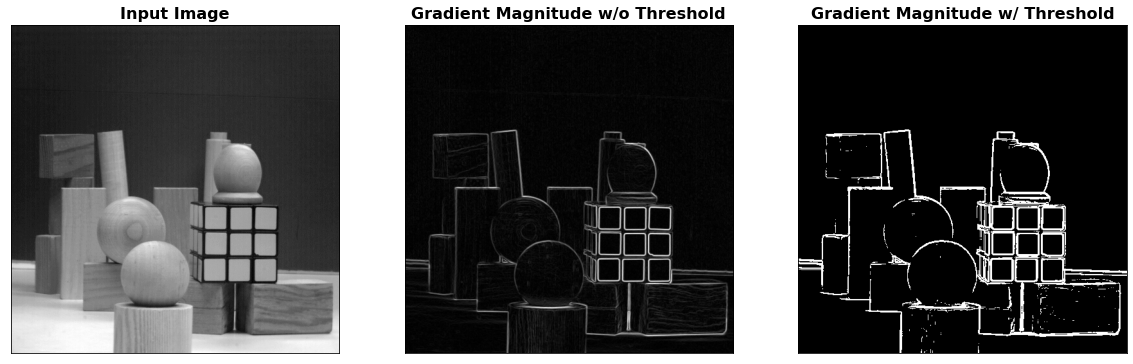

In [3]:
# Part 1. Compute the Gradient Magnitude
grad_mag = np.sqrt(np.square(Sx) + np.square(Sy))

threshold = (grad_mag >= 90) * 255.0
grad_mag_final = np.reshape(threshold, grad_mag.shape)

# Show your results on the blocks image
plt.subplot(131)
plt.imshow(original,cmap="gray")
just_title('Input Image')

plt.subplot(132)
plt.imshow(grad_mag,cmap="gray")
just_title('Gradient Magnitude w/o Threshold')

plt.subplot(133)
plt.imshow(grad_mag_final,cmap="gray")
just_title('Gradient Magnitude w/ Threshold')

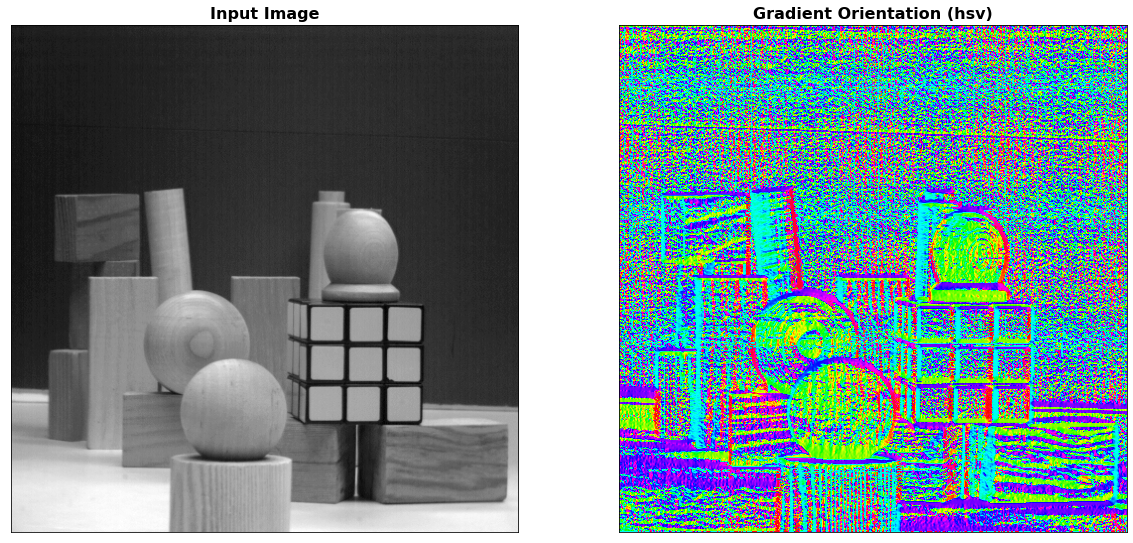

In [4]:
# Part 2. Compute the Gradient Orientation
grad_orient = np.arctan2(Sy, Sx)

# Show your results on the blocks image
plt.subplot(121)
plt.imshow(original,cmap="gray")
just_title('Input Image')

plt.subplot(122)
plt.imshow(grad_orient,cmap="hsv")
just_title('Gradient Orientation (hsv)')

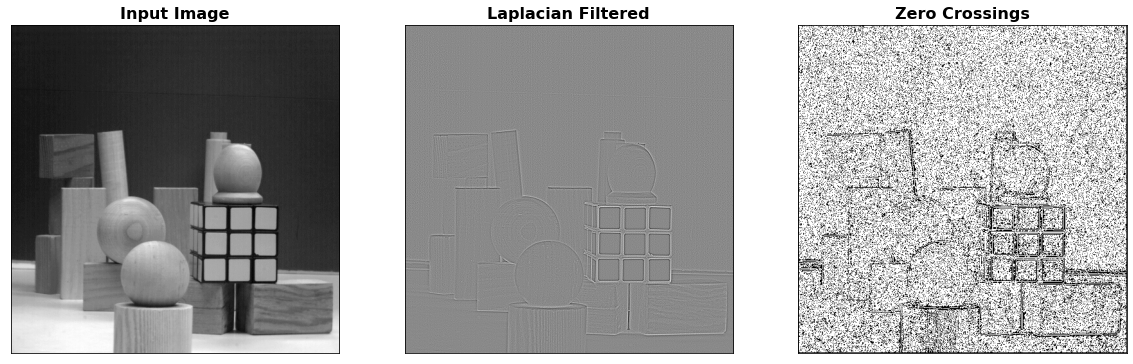

In [5]:
# Part 3. Find the Zero Crossings
lap_original = cv2.imread("blocks.png", 0).astype(np.float64)
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
lap_filtered = cv2.filter2D(lap_original, -1, laplacian_kernel)
zero_crossings = np.zeros(lap_filtered.shape, dtype=np.float64)

for r in range(1, lap_filtered.shape[0]-1):
    for c in range(1, lap_filtered.shape[1]-1):
        if (lap_filtered[r][c] * lap_filtered[r][c-1]) < 0:
            zero_crossings[r][c] = 1
        if (lap_filtered[r][c] * lap_filtered[r-1][c]) < 0:
            zero_crossings[r][c] = 1

# Show the results on blocks image
plt.subplot(131)
plt.imshow(original,cmap="gray")
just_title('Input Image')

plt.subplot(132)
plt.imshow(lap_filtered,cmap="gray")
just_title('Laplacian Filtered')

plt.subplot(133)
plt.imshow(zero_crossings,cmap="gray")
just_title('Zero Crossings')

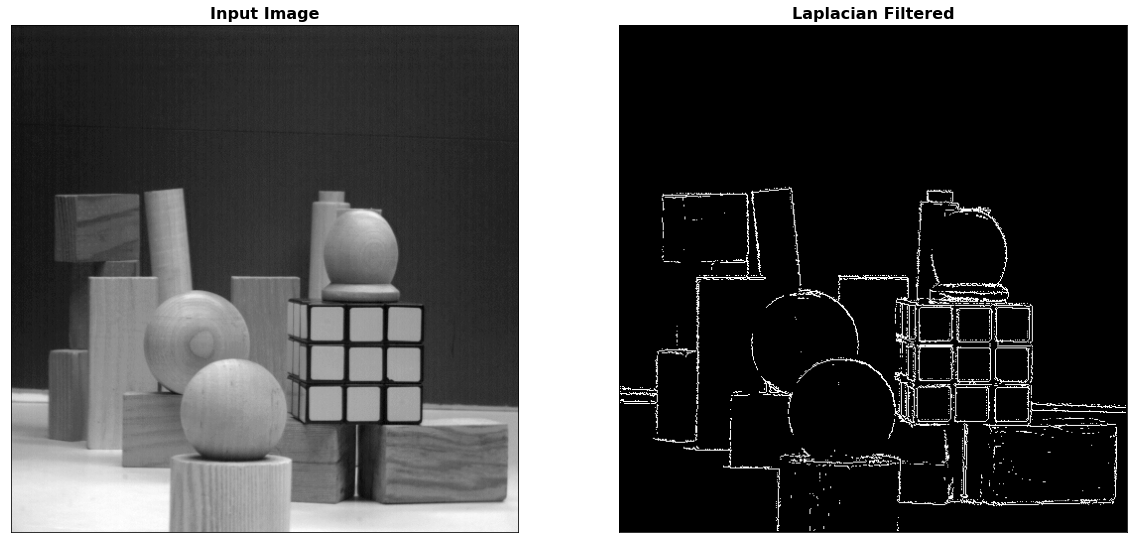

In [6]:
# Part 4. Final Solution With edges found
final = np.zeros(lap_filtered.shape, dtype=np.float64)

for row in range(1, final.shape[0]-1):
    for col in range(1, final.shape[1]-1):
        # Using threshold found in part 1 and zero_crossings found in part 3
        if grad_mag_final[row][col] and zero_crossings[row][col]:
            final[row][col] = 255.0

# Show the results on blocks image
plt.subplot(121)
plt.imshow(original,cmap="gray")
just_title('Input Image')

plt.subplot(122)
plt.imshow(final,cmap="gray")
just_title('Laplacian Filtered')

In [7]:
def get_image(name):
    original_circles = cv2.imread(name).astype(np.float32)
    original_circles = original_circles/np.amax(original_circles)
    circles = np.zeros(original_circles.shape)
    circles[:,:,0] = original_circles[:,:,2]
    circles[:,:,1] = original_circles[:,:,1]
    circles[:,:,2] = original_circles[:,:,0]
    return circles

def detect_edges(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    image = cv2.GaussianBlur(image, (3,3), cv2.BORDER_DEFAULT)
    Sx = cv2.filter2D(image, -1, sobel_x)
    Sy = cv2.filter2D(image, -1, sobel_y)

    return np.sqrt(np.square(Sx) + np.square(Sy))

def add_threshold(image, threshold=0.6):
    return np.reshape((image >= threshold) * 255.0, image.shape)

def get_all_edges(image):
    blue_circles = image[:,:,0]
    green_circles = image[:,:,1]
    red_circles = image[:,:,2]

    blue_edges = detect_edges(blue_circles)
    blue_threshold = add_threshold(blue_edges)

    green_edges = detect_edges(green_circles)
    green_threshold = add_threshold(green_edges)

    red_edges = detect_edges(red_circles)
    red_threshold = add_threshold(red_edges)

    return np.add(blue_threshold, green_threshold, red_threshold)

def hough(image, r):
    accumulator = np.zeros((image.shape[0],image.shape[0]))
    thetas = np.deg2rad(np.arange(0, 360))
    
    for x in range(0, image.shape[0]):
        for y in range(0, image.shape[1]):
            if image[x][y] > 0:
                for t in thetas:
                    a = int(x - r * np.cos(t))
                    b = int(y - r * np.sin(t))
                    if a > 0 and a < image.shape[0] and b > 0 and b < image.shape[1]:
                        accumulator[a][b] += 1
    return accumulator

def peak_neighbor(x, y, peaks, r):
    for y_coord, x_coord in peaks:
        if np.abs(y - y_coord) < r and np.abs(x - x_coord) < r:
            return False
    return True

def find_peak(image, x, y, peaks, r):
    neighborhood = image[x:x+r, y:y+r]
    if peak_neighbor(x, y, peaks, r):
        peaks.append((y,x))
    return peaks

def check_peaks(image, peak_radius):
    peaks = [(0,0)]
    for x in np.arange(image.shape[0]):
        for y in np.arange(image.shape[1]):
            if image[x][y] > 0:
                peaks = find_peak(image, x, y, peaks, peak_radius)
    return peaks[1:-1]

In [8]:
# Part B - Hough Transform - get the original image
circles = get_image("circles.png")
all_edges = get_all_edges(circles)

In [9]:
##### HOUGH 16 ########

# Get the accumulator
hough_16 = hough(all_edges, 16)

# Check that the point is at least a certain percentage of the maximum value in the accumulator (threshold)
final_hough_16 = add_threshold(hough_16, 0.64*np.amax(hough_16))

# Check that the pixel is a maximum in it's own area
peaks_16 = check_peaks(final_hough_16, 15)
test = final_hough_16.copy()

final_hough_16 = circles.copy()

for center in peaks_16:
    final_hough_16 = cv2.circle(final_hough_16, center, 16, (255, 0, 0), 3)

In [10]:
##### HOUGH 32 ########

# Get the accumulator
hough_32 = hough(all_edges, 32)

# Check that the point is at least a certain percentage of the maximum value in the accumulator (threshold)
final_hough_32 = add_threshold(hough_32, 0.5*np.amax(hough_32))

# Check that the pixel is a maximum in it's own area
peaks_32 = check_peaks(final_hough_32, 5)
final_hough_32 = circles.copy()

for center in peaks_32:
    final_hough_32 = cv2.circle(final_hough_32, center, 32, (0, 255, 0), 3)

In [11]:
##### HOUGH 48 ########

# Get the accumulator
hough_48 = hough(all_edges, 48)

# Check that the point is at least a certain percentage of the maximum value in the accumulator (threshold)
final_hough_48 = add_threshold(hough_48, 0.69*np.amax(hough_48))

# Check that the pixel is a maximum in it's own area
peaks_48 = check_peaks(final_hough_48, 3)
final_hough_48 = circles.copy()

for center in peaks_48:
    final_hough_48 = cv2.circle(final_hough_48, center, 48, (0, 0, 255), 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Small Circle Center Locations:
[(18, 74), (88, 114), (27, 143), (89, 194), (51, 196)]

Medium Circle Center Locations:
[(45, 30), (72, 32), (149, 32), (57, 33), (218, 34), (157, 66), (88, 113), (45, 180), (172, 189), (184, 206)]

Large Circle Center Locations:
[(88, 114), (71, 204)]



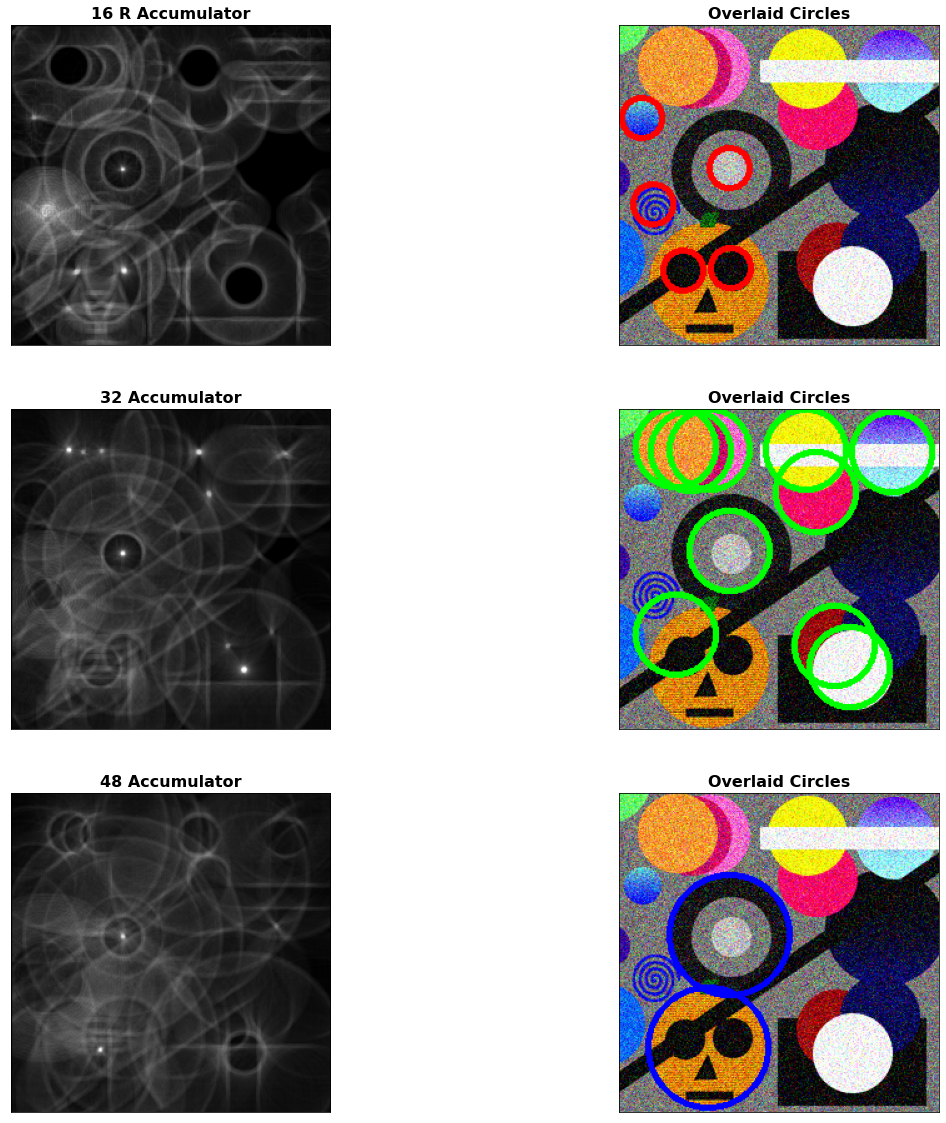

In [12]:
print("Small Circle Center Locations:")
print(peaks_16)
print()

print("Medium Circle Center Locations:")
print(peaks_32)
print()

print("Large Circle Center Locations:")
print(peaks_48)
print()

# Be sure to show all of the figures required in the description above
plt.subplots(3,2, figsize=(20, 20))

#Plot Hough 16
plt.subplot(321)
plt.imshow(hough_16, cmap='gray')
just_title('16 R Accumulator')

plt.subplot(322)
plt.imshow(final_hough_16)
just_title('Overlaid Circles')

#Plot Hough 32
plt.subplot(323)
plt.imshow(hough_32, cmap='gray')
just_title('32 Accumulator')

plt.subplot(324)
plt.imshow(final_hough_32)
just_title('Overlaid Circles')

#Plot Hough 48
plt.subplot(325)
plt.imshow(hough_48, cmap='gray')
just_title('48 Accumulator')

plt.subplot(326)
plt.imshow(final_hough_48)
just_title('Overlaid Circles')